# Results of Data Analysis

* based on the histogram of order count variable - we can see that most products are sold between 0-10 times
    
* based on the histogram of number of products sold by the vendor - we can see that most of the vendors sell under 100 products

* Rice is one of the most popular items sold

* For one of the clusters, a top selling vendor is at the border of two clusters as defined by k-means

* Certain dishes like rice, instant noodles, spring chicken meal are popular across clusters.

# Further Steps

* We have looked at the dataset provided - performed cluster analysis and modelled using 2 baseline approaches and matrix factorization based approaches

* We consider 2 clustering methods - kmeans and dbscan. From visual inspection we can conclude that kmeans has a better categorization of the vendors. We didn't look at error of these clustering methods in detail

* A nice way of evaluate and improve clustering methods would be also to look at errors and estimate numerically which cluster is better. This could be done by calculating distance to centroid of each point and summing it up

* To improve the existing models we could also incorporate item features that has been generated from the similarity baseline. Here we could use pre-trained word-embedding models or train one ourselves depending on the size of data.

* We could also incorporate vendor demographic data. For ex. like distance to the city center etc.(if it was available) to account for the biases involved in selling these items

* For similarity based we have considered top 100 items as recommendable products. For similar products this means that most vendors end up getting similar recommendations. This could be fixed by considering a dynamic recommendable list for each vendor either randomly or by using some business rationale. Additionally, by considering a bigger computational set up - the 100 recommendable products could be extended to may be 1000

* For SVD we have also used a dynamic list of 100 products as recommendable products - but here we choose random 100 products from the list of all recommendable products for each vendor. With a bigger computational set up we could end up considering more products per vendor.

* The code is not fully optimized - can be further refactored for better readability. Also in a production setting we would need to have unit testing fully integrated to ensure that the code won't break under any circumstances

* We averaged product name and product description features to keep it simple. Ideally we could do a weighted average rather. For example. we could consider product vector to be 0.6 x product_name_vector + 0.4 x product_description_vector especially since product description is missing for 60% of the products

* From a modelling perspective we could also see that many of the same dishes get different product ids from different vendors. We could consider this in the modelling phase when we compute the recommendable products list and generate a distinct product list based on product names rather than product id's

In [1]:
! pip3 install -r dh_requirements.txt

In [2]:
#numpy and pandas
import numpy as np
import pandas as pd
import scipy

#graphing imports
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns

#config imports
import warnings; warnings.simplefilter('ignore')
pd.options.display.max_rows = 4000
pd.options.display.max_colwidth = 4000
pd.options.display.max_columns = None

#library imports for data processing
import datetime
from functools import reduce
import boto
import regex
import pygeohash as pgh
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
nltk.download('stopwords')

#pre-processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#models
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cosine
from scipy.spatial.distance import euclidean
import gensim.downloader as api
from surprise import Reader, Dataset
from surprise import SVD
from surprise import NMF
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import BaselineOnly

#evaluation
from surprise.model_selection import GridSearchCV
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/prasanna.ramaswamy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/prasanna.ramaswamy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Reading

In [3]:
"""function to read data
    Parameters
    ----------

    Returns
    ----------
    all_data : pd.DataFrame()
        DataFrame of the data
"""
def read_data():
    try:
        fh = open('data_parquet','r')
    except:
    # if file does not exist, create it
        fh = open('data_parquet','w')

    conn = boto.connect_s3(anon=True)
    b = conn.get_bucket("dh-data-chef-hiring-test", validate=False)
    k = boto.s3.key.Key(b)
    k.key = "products.gz"
    k.get_contents_to_filename('data_parquet')
    all_data = pd.read_parquet('data_parquet', engine='fastparquet')
    return all_data

all_data = read_data()

In [5]:
"""function to perform basic preprocessing of data - 
clean the product name by removing foreign language characters
decode geohash into latitude and longitude columns
    Parameters
    ----------
    all_data : pd.DataFrame()
        Dataframe with the read data
        
    Returns
    ----------
    all_data : pd.DataFrame()
        preprocessed DataFrame with cleaned product data, latitude and longitude columns
"""
def preprocess_data(all_data):
    #removing foreign characters
    all_data['product_name_cleaned'] = all_data['product_name'].apply(lambda x : regex.sub(r'[^\x00-\x7f]',r'',x))
    all_data['product_description_cleaned'] = all_data['product_description'].apply(lambda x : regex.sub(r'[^\x00-\x7f]',r'',x) if x is not None else None)

    #decoding vendor geohash into coordinates
    all_data['lat_long'] = all_data['vendor_geohash'].apply(lambda x : pgh.decode(x))
    all_data['latitude'] = all_data['lat_long'].apply(lambda x : x[0])
    all_data['longitude'] = all_data['lat_long'].apply(lambda x : x[1])
    #stripping the product name
    all_data[['product_name_cleaned']] = all_data[['product_name_cleaned']].apply(lambda x : x.str.strip())
    all_data[['product_description_cleaned']] = all_data[['product_description_cleaned']].apply(lambda x: x.str.strip())
    #removing white spaces
    all_data[['product_name_cleaned']] = all_data['product_name_cleaned'].apply(lambda x : re.sub(' +',' ',x))
    all_data[['product_description_cleaned']] = all_data['product_description_cleaned'].apply(lambda x : re.sub(' +',' ',x) if x is not None else None)
    #removing products called Dry since it doesn't probably make much sense
    all_data = all_data[all_data['product_name_cleaned'] != 'Dry']
    #removing products that had only foreign character name
    all_data = all_data[~(all_data['product_name_cleaned']=="")]
    
    
    return all_data
    
all_data = preprocess_data(all_data)

In [6]:
all_data.isnull().sum()

product_id                          0
vendor_id                           0
vendor_geohash                      0
product_name                        0
product_description            184211
order_count                         0
product_name_cleaned                0
product_description_cleaned    184211
lat_long                            0
latitude                            0
longitude                           0
dtype: int64

# Clustering

In [7]:
"""function to return latitude and longitude data of vendors
    Parameters
    ----------
    all_data : pd.DataFrame()
        Dataframe with the read data
        
    Returns
    ----------
    vendor_data : pd.DataFrame()
        id's of vendors
    kmeans_data : pd.DataFrame()
        latitude and longitude of vendors to be used for kmeans clusters
    DBSCAN_data : pd.DataFrame()
        latitude and longitude of vendors to be used for kmeans clusters
    
"""
def create_data_for_clustering(all_data):
    all_data_subset = all_data[['vendor_id','latitude','longitude']].drop_duplicates(subset=['vendor_id'])[['latitude','longitude']].reset_index(drop=True)
    kmeans_data = all_data_subset.copy()
    dbscan_data = all_data_subset.copy()
    vendor_data = all_data[['vendor_id']].drop_duplicates().reset_index(drop=True)
    
    return vendor_data, kmeans_data, dbscan_data
    
vendor_data, kmeans_data, dbscan_data = create_data_for_clustering(all_data)

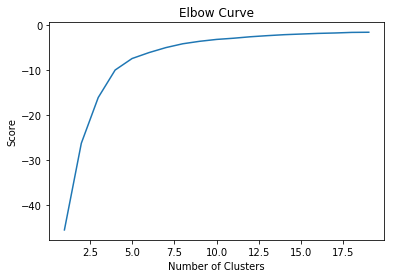

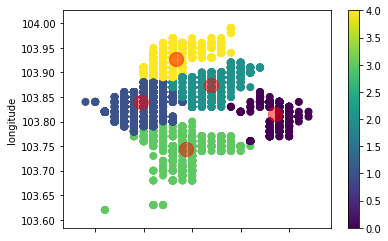

In [8]:
"""function to calculate kmeans clusters and visualize
    Parameters
    ----------
    kmeans_data : pd.DataFrame()
        latitude and longitude of vendors to be used for kmeans clusters
        
    Returns
    ----------
    kmeans_data : pd.DataFrame()
        latitude and longitude of vendors to be used for kmeans clusters
"""
def create_kmeans_clusters(kmeans_data):
    #running the elbow method for kmeans - we can see that k = 5 the score reaches the elbow point 
    K_clusters = range(1,20)
    kmeans = [KMeans(n_clusters=i) for i in K_clusters]
    score = [kmeans[i].fit(kmeans_data).score(kmeans_data) for i in range(len(kmeans))]
    # Visualize
    plt.plot(K_clusters, score)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Elbow Curve')
    plt.show()
    
    kmeans = KMeans(n_clusters = 5, init ='k-means++')
    kmeans.fit(kmeans_data) # Compute k-means clustering.
    kmeans_data['cluster_label'] = kmeans.fit_predict(kmeans_data)
    kmeans_centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
    kmeans_labels = kmeans.predict(kmeans_data[['latitude','longitude']]) # Labels of each point
    
    kmeans_data.plot.scatter(x = 'latitude', y = 'longitude', c=kmeans_labels, s=50, cmap='viridis')
    plt.scatter(kmeans_centers[:, 0], kmeans_centers[:, 1], c='red', s=200, alpha=0.5)
    plt.show()
    
    return kmeans_data

kmeans_data_with_clusters = create_kmeans_clusters(kmeans_data)

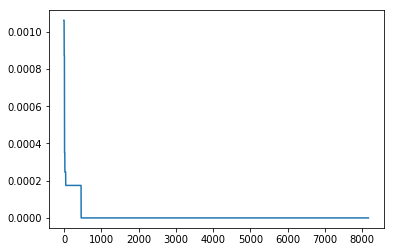

Number of clusters: 10


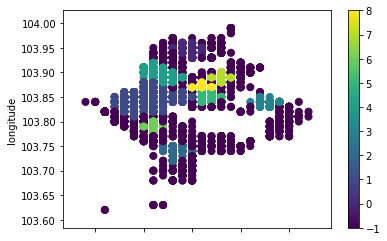

In [9]:
"""function to calculate dbscan clusters and visualize
    Parameters
    ----------
    dbscan_data : pd.DataFrame()
        latitude and longitude of vendors to be used for kmeans clusters
        
    Returns
    ----------
    dbscan_data : pd.DataFrame()
        latitude and longitude of vendors to be used for kmeans clusters
"""
def create_dbscan_clusters(dbscan_data):
    
    #estimating eps value
    ns = 10
    nbrs = NearestNeighbors(n_neighbors=ns, algorithm='ball_tree',metric='haversine').fit(np.radians(dbscan_data.as_matrix()))
    dist, ix = nbrs.kneighbors(np.radians(dbscan_data.as_matrix()))
    distancelist = sorted(dist[:,ns-1], reverse=True)
    plt.plot(list(range(1,8173)), distancelist)
    plt.show()

    #based on the graph above we can determine that at around 0.0002 the elbow of the graph occurs which is roughly 1.5/6371
    db = DBSCAN(eps=1.5/6371, min_samples=200, algorithm='ball_tree', metric='haversine').fit(np.radians(dbscan_data.as_matrix()))
    
    db_labels = db.labels_
    num_db_clusters = len(set(db_labels))
    db_clusters = pd.Series([dbscan_data.as_matrix()[db_labels == n] for n in range(num_db_clusters)])
    print('Number of clusters: {}'.format(num_db_clusters))
    
    dbscan_data = pd.concat([dbscan_data, pd.DataFrame(db.labels_, columns=['cluster_label'])], axis = 1)
    dbscan_data.plot.scatter(x = 'latitude', y = 'longitude', c=db_labels, s=50, cmap='viridis')
    plt.show()
    
    return dbscan_data

dbscan_data_with_clusters = create_dbscan_clusters(dbscan_data)

## Based on the above graphs we can see that k-means is performing a better job at clustering than dbscan - we will use the cluster index as defined by k-means to perform analysis

# Data Analysis

In [11]:
"""function to combine vendor clusters into original data
    Parameters
    ----------
    vendor_data : pd.DataFrame()
        dataframe with vendor id's
    kmeans_data_with_clusters: pd.DataFrame()
        kmeans data with clusters
    all_data: pd.DataFrame()
        all data
    
    Returns
    ----------
    all_data : pd.DataFrame()
        all_data with cluster info
"""
def combine_with_original_data(vendor_data, kmeans_data_with_clusters, all_data):
    vendor_data_with_clusters = pd.concat([vendor_data, kmeans_data_with_clusters], axis=1)[['vendor_id','cluster_label']]
    all_data = pd.merge(all_data, vendor_data_with_clusters, on='vendor_id')
    return all_data

all_data = combine_with_original_data(vendor_data, kmeans_data_with_clusters, all_data)

priting histogram of orders of products


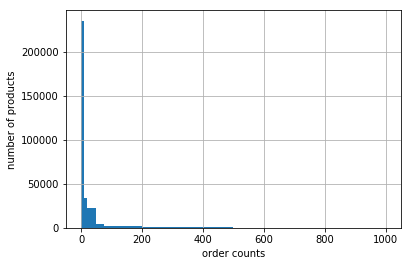

printing histogram of number of products sold by the vendor


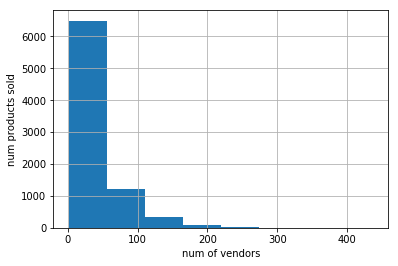

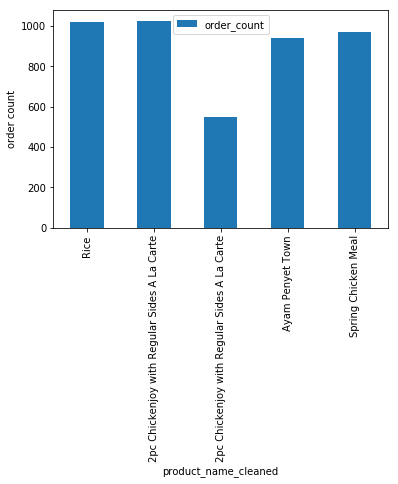

printing top 5 selling items across each cluster 



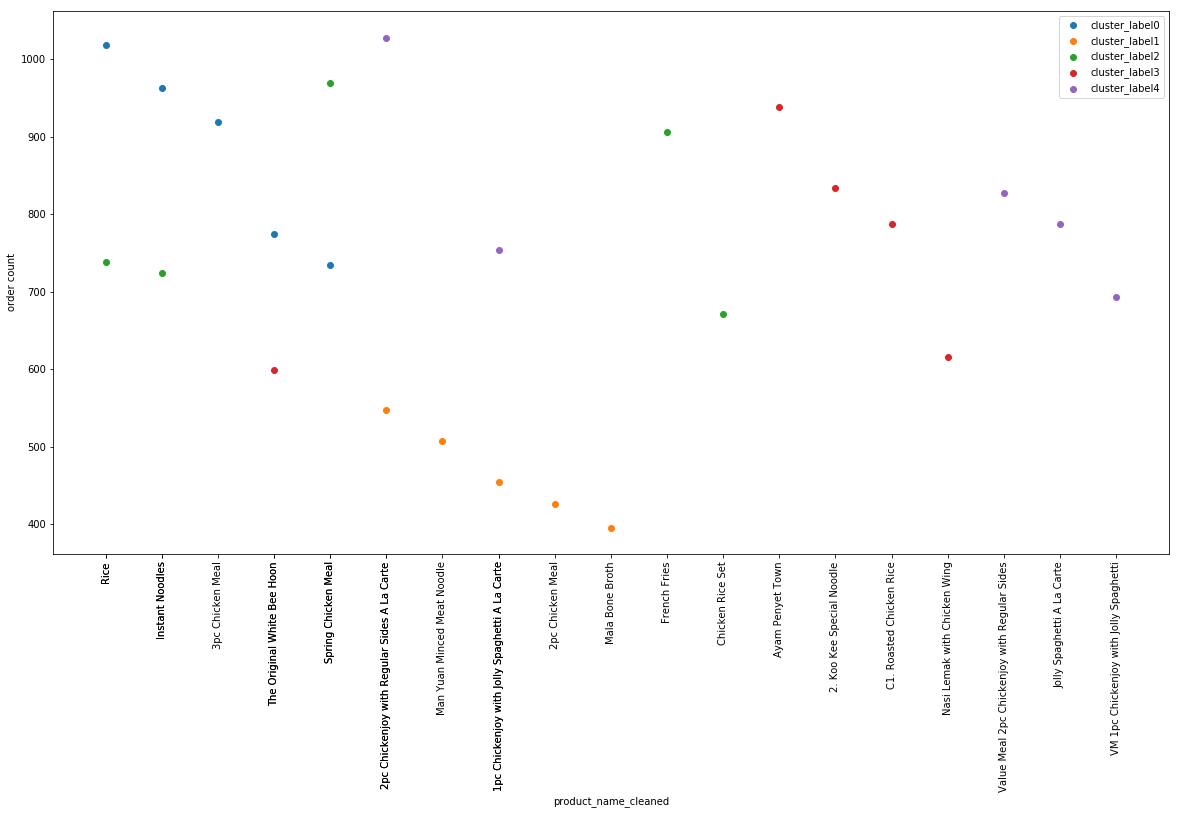

printing vendors with highest total items sold per cluster 



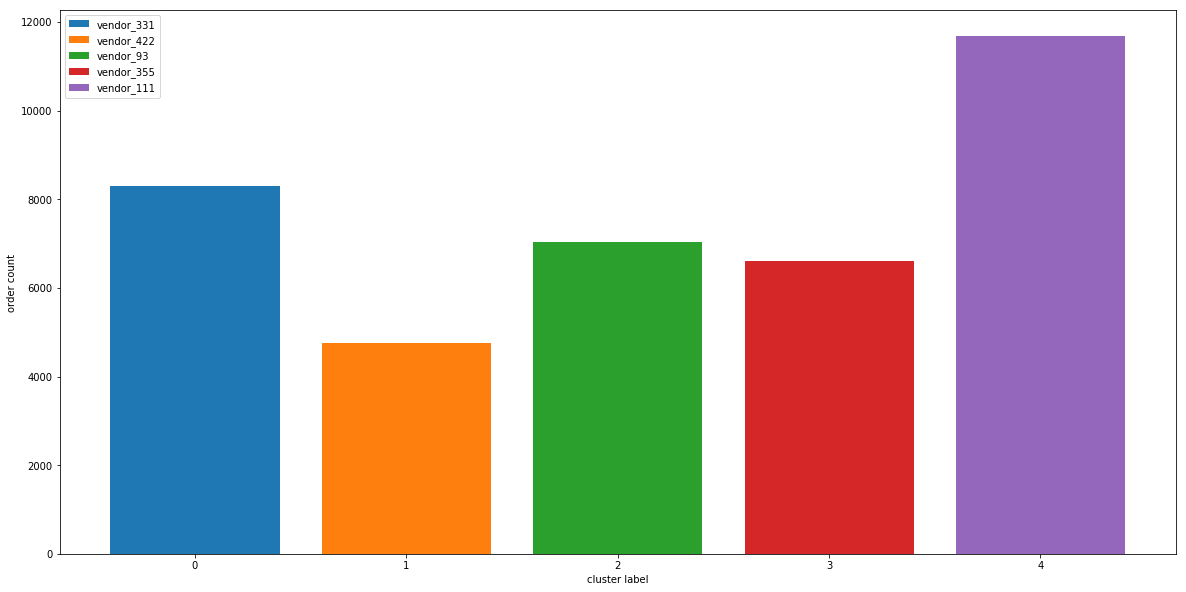

printing best-selling items from high selling vendors


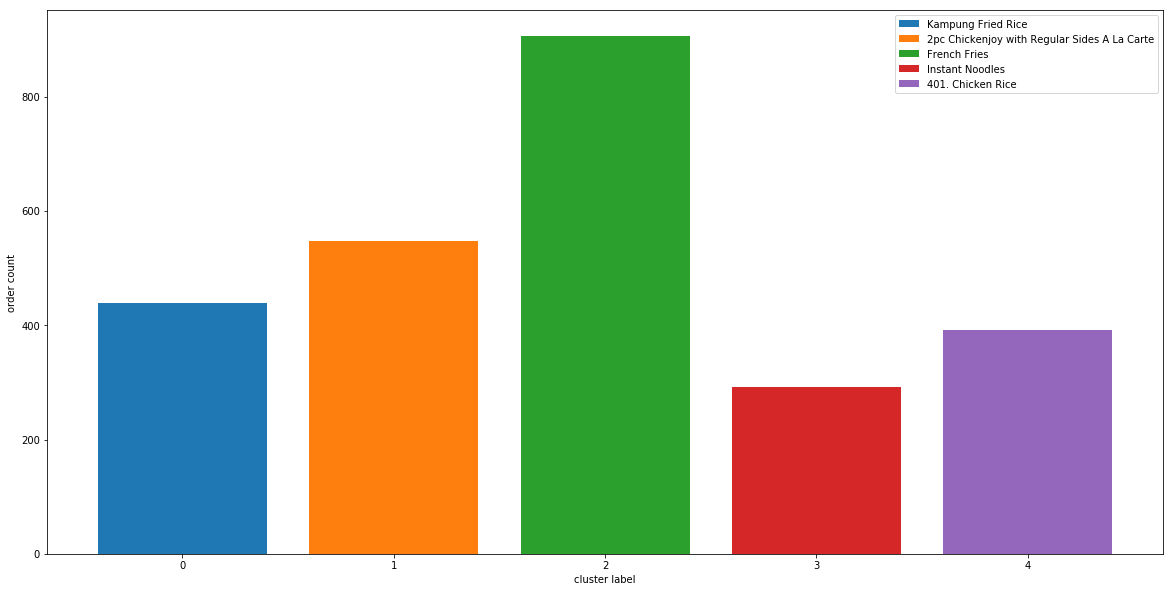

printing the geographical location of top sellers in each cluster 



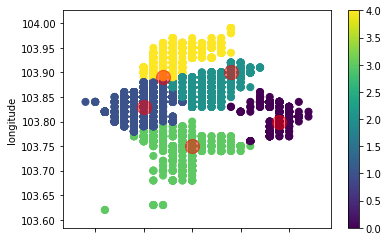

best selling items sold per cluster 



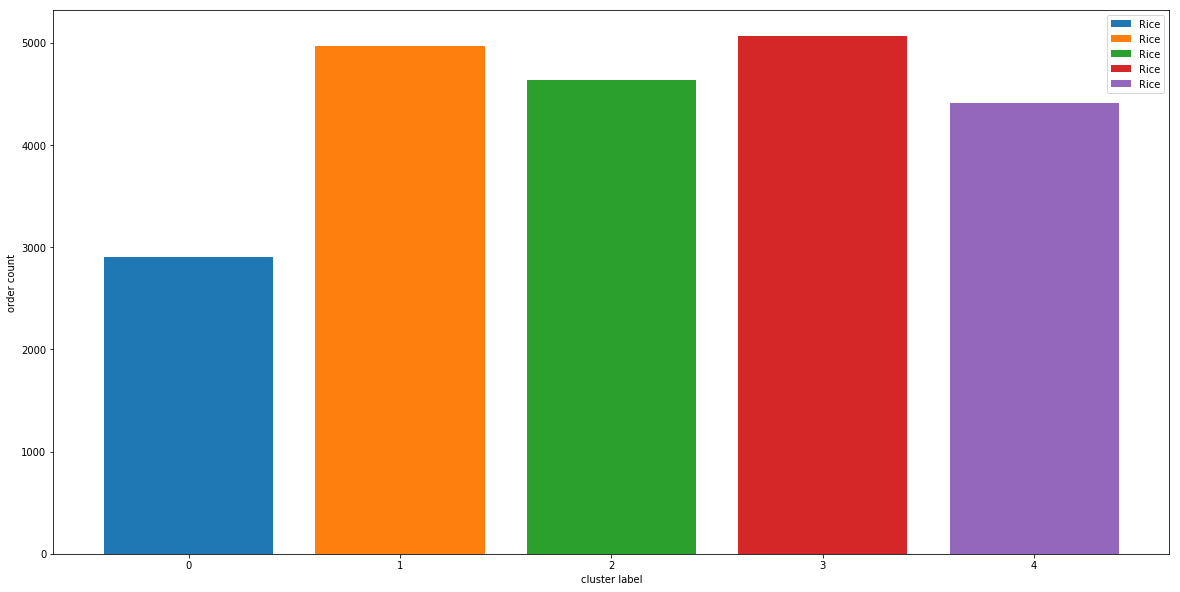

In [23]:
"""function to perform data analysis
    Parameters
    ----------
    all_data: pd.DataFrame()
        all data
    num_clusters: num of clusters returned from the clustering algorithm
    
    Returns
    ----------

"""
def perform_data_analysis(all_data, num_clusters = 5):
    
    """priting histogram of order count variable - we can see that most products are sold between 0-10 times"""
    print("priting histogram of orders of products")
    bins = [0,10,20,50,75,100,200,500,1000]
    all_data['order_count'].hist(bins=bins)
    plt.xlabel('order counts')
    plt.ylabel('number of products')
    plt.show()
    
    """printing histogram of number of products sold by the vendor - we can see that most of the vendors sell under
    100 products"""
    print("printing histogram of number of products sold by the vendor")
    bins = [0,10,20,50,75,100,200,500,1000]
    all_data.groupby(['vendor_id'])['product_id'].nunique().hist(bins=8)
    plt.xlabel('num of vendors')
    plt.ylabel('num products sold')
    plt.show()

    """printing the best selling item across each cluster"""
    print("best selling items across each cluster")
    idx = all_data.groupby(['cluster_label'])['order_count'].transform(max) == all_data['order_count']
    all_data[idx][['cluster_label','product_name_cleaned', 'order_count']].plot.bar(x='product_name_cleaned', y='order_count')
    plt.ylabel('order count')
    plt.show()

    """printing top 5 selling items across each cluster - some items across these clusters are shared as a result I chose to
    display a scatter plot to point that some items will have 2 data points - from different cluster - for ex. rice"""
    print("printing top 5 selling items across each cluster \n")
    temp = all_data.groupby(['cluster_label'])['order_count'].apply(lambda x : x.sort_values(ascending=False)[:5]).reset_index()[['cluster_label','order_count']]
    temp = pd.merge(temp, all_data, on=['order_count','cluster_label'])[['cluster_label','product_name_cleaned','order_count']]
    df_list = [None] * num_clusters
    for i in range(num_clusters):
        df_list[i] = temp[temp['cluster_label']==i]

    fig, ax = plt.subplots(figsize=(20,10))
    cluster_label = [None] * num_clusters
    for i in range(num_clusters):
        plt.scatter(df_list[i]['product_name_cleaned'],df_list[i]['order_count'])
        cluster_label[i] = "cluster_label"+str(i)
    
    plt.legend(cluster_label)
    plt.xlabel('product_name_cleaned')
    plt.xticks(temp.product_name_cleaned.values.tolist(), rotation=90)
    plt.ylabel('order count')
    plt.show()
    
    """vendors with highest total items sold per cluster"""
    print("printing vendors with highest total items sold per cluster \n")
    sum_per_vendor_cluster = all_data.groupby(['cluster_label','vendor_id'])['order_count'].sum().sort_values(ascending=False).reset_index()
    max_order_per_cluster = all_data.groupby(['cluster_label','vendor_id'])['order_count'].sum().sort_values(ascending=False).reset_index().groupby(['cluster_label'])['order_count'].nlargest(1).reset_index()[['order_count']]
    temp = pd.merge(sum_per_vendor_cluster, max_order_per_cluster, on='order_count')

    df_list = [None] * num_clusters
    for i in range(num_clusters):
        df_list[i] = temp[temp['cluster_label']==i]


    fig, ax = plt.subplots(figsize=(20,10))
    vendor_label = [None] * num_clusters
    for i in range(num_clusters):
        plt.bar(df_list[i]['cluster_label'],df_list[i]['order_count'])
        vendor_label[i] = "vendor_"+str(df_list[i].vendor_id.values[0])

    plt.ylabel('order count')
    plt.xlabel('cluster label')
    plt.legend(vendor_label)
    plt.show()
    
    """we print the order counts of numbers that sell the most for the max selling vendor in each cluster"""
    print("printing best-selling items from high selling vendors")
    vendor_with_all_products = pd.merge(temp['vendor_id'],all_data,on='vendor_id')
    vendor_with_max_orders = vendor_with_all_products.groupby(['vendor_id', 'cluster_label', 'product_name_cleaned'])['order_count'].max().sort_values(ascending=False).reset_index().drop_duplicates(['vendor_id'],keep='first')[['vendor_id','product_name_cleaned','order_count', 'cluster_label']].reset_index(drop=True)

    df_list = [None] * num_clusters
    for i in range(num_clusters):
        df_list[i] = vendor_with_max_orders[vendor_with_max_orders['cluster_label']==i]

    fig, ax = plt.subplots(figsize=(20,10))

    product_label = [None] * num_clusters
    for i in range(num_clusters):
        plt.bar(df_list[i]['cluster_label'],df_list[i]['order_count'])
        product_label[i] = str(df_list[i].product_name_cleaned.values[0])

    plt.ylabel('order count')
    plt.xlabel('cluster label')
    plt.legend(product_label)
    plt.show()
    
    """for the vendors that perform the best across the clusters - we look at their geographical location"""
    print("printing the geographical location of top sellers in each cluster \n")
    temp = pd.merge(temp['vendor_id'], all_data.drop_duplicates(subset=['vendor_id']),on='vendor_id')
    vendor_coordinates = np.zeros((temp.shape[0], 2))
    for i in range(temp.shape[0]):
        vendor_coordinates[i] = np.array([temp['latitude'][i], temp['longitude'][i]])

    vendor_data_with_clusters = all_data[['latitude','longitude', 'cluster_label', 'vendor_id']].drop_duplicates(subset=['vendor_id']).reset_index(drop=True)
    vendor_data_with_clusters[['latitude','longitude']].plot.scatter(x = 'latitude', y = 'longitude', c=vendor_data_with_clusters['cluster_label'].values, s=50, cmap='viridis')
    plt.scatter(vendor_coordinates[:, 0], vendor_coordinates[:, 1], c='red', s=200, alpha=0.5)
    plt.show()
    
    """next we plot max items sold per cluster - we can see that it is rice across all clusters sells the most"""
    print("best selling items sold per cluster \n")
    sum_per_product_cluster = all_data.groupby(['cluster_label','product_name_cleaned'])['order_count'].sum().sort_values(ascending=False).reset_index()
    max_order_per_cluster = all_data.groupby(['cluster_label','product_name_cleaned'])['order_count'].sum().sort_values(ascending=False).reset_index().groupby(['cluster_label'])['order_count'].nlargest(1).reset_index()[['order_count']]
    temp = pd.merge(sum_per_product_cluster, max_order_per_cluster, on='order_count')

    df_list = [None] * num_clusters
    for i in range(num_clusters):
        df_list[i] = temp[temp['cluster_label']==i]

    fig, ax = plt.subplots(figsize=(20,10))
    product_label = [None] * num_clusters
    for i in range(num_clusters):
        plt.bar(df_list[i]['cluster_label'],df_list[i]['order_count'])
        product_label[i] = str(df_list[i].product_name_cleaned.values[0])

    plt.ylabel('order count')
    plt.xlabel('cluster label')
    plt.legend(product_label)
    plt.show()

perform_data_analysis(all_data, all_data.cluster_label.nunique())

# Modelling

In [13]:
"""some user defined functions to facilitate the baseline calculations
for popularity and similarity
"""
def set_operation(x, col1, col2):
        return list(set(x[col1]) - set(x[col2]))
    
def top_k_list(x, col1, n):
        return x[col1][:n]
    
def average_vectors(x):
    vector_list = [model[word] for word in x if word in model.vocab]
    return np.mean(vector_list, axis=0)

def euclidean_distance(x, y):
    np.sqrt(np.sum((x-y)))

In [24]:
"""function to combine vendor clusters into original data
    Parameters
    ----------
    all_data : pd.DataFrame()
        dataframe with all data
    num_recommended_prods: int
        total number of recommended products
    
    Returns
    ----------
    merged_data : pd.DataFrame()
        vendor dataframe with recommended products and product names
"""
def recommend_top_n_items_cluser_popularity(all_data, num_recommended_prods=5, num_recommendable_prods=50):
    all_data.drop_duplicates(subset=['vendor_id'])[['vendor_id','cluster_label']].reset_index(drop=True)
    
    #creating list of product names and products at vendor_id level
    all_data_subset = pd.concat(
        [
            all_data.groupby(['vendor_id'])['product_id'].apply(lambda x : x.tolist()).reset_index()[['vendor_id','product_id']]
            ,all_data.groupby(['vendor_id'])['product_name_cleaned'].apply(lambda x : x.tolist()).reset_index()[['product_name_cleaned']]
        ]
        ,axis=1
    )
    
    #creating vendor data with cluster info
    vendor_data_with_cluster = all_data.drop_duplicates(subset=['vendor_id'])[['vendor_id','cluster_label']].reset_index(drop=True)
    
    #joining it back with the all_data_subset dataframe to get products sold 
    vendor_products = pd.merge(vendor_data_with_cluster, all_data_subset, on='vendor_id')
    vendor_products = vendor_products.rename(columns={'product_id':'products_already_selling', 'product_name_cleaned':'products_already_selling_names'})

    #getting the top 50 best selling items in the respective clusters for recommendation
    best_products_per_cluster = all_data.loc[all_data.groupby(['cluster_label'])['order_count'].nlargest(num_recommendable_prods).reset_index()['level_1']]
    
    #creating a list of top products and product names at cluster level    
    top_products_per_cluster_grouped = best_products_per_cluster[['cluster_label','product_id','product_name_cleaned']].groupby(['cluster_label']).agg(lambda x: x.tolist()).reset_index()

    #renaming columns for final processing
    top_products_per_cluster_grouped = top_products_per_cluster_grouped.rename(columns={'product_id':'top_products','product_name_cleaned':'top_product_name'})
    
    #merging top products data with vendor products
    merged_data = pd.merge(top_products_per_cluster_grouped, vendor_products, on='cluster_label')
    
    #subtracting the respective lists to get top products not already sold by the vendor
    merged_data['recommended_products'] = merged_data.apply(lambda x : set_operation(x, 'top_products','products_already_selling'), axis=1)
    merged_data['recommended_products_name'] = merged_data.apply(lambda x : set_operation(x, 'top_product_name','products_already_selling_names'), axis=1)
    
    #getting top n recommendations for each vendor
    merged_data['top_n_recommended_products'] = merged_data.apply(lambda x : top_k_list(x, 'recommended_products', num_recommended_prods), axis=1)
    merged_data['top_n_recommended_products_name'] = merged_data.apply(lambda x : top_k_list(x, 'recommended_products_name', num_recommended_prods), axis=1)

    return merged_data[['vendor_id','top_n_recommended_products','top_n_recommended_products_name', 'cluster_label']]

popular_items = recommend_top_n_items_cluser_popularity(all_data, 5, 50)

In [25]:
popular_items.head()

,vendor_id,top_n_recommended_products,top_n_recommended_products_name,cluster_label
0,12,"[8709, 3208, 26377, 22922, 1292]","[Beef Fried Rice, 3pc Chicken Meal, 1/2 Spring Chicken Meal, Seafood Hor Fun, Fried Hokkien Mee]",0
1,16,"[8709, 3208, 26377, 22922, 1292]","[Beef Fried Rice, 3pc Chicken Meal, 1/2 Spring Chicken Meal, Seafood Hor Fun, Fried Hokkien Mee]",0
2,26,"[8709, 3208, 26377, 22922, 1292]","[Beef Fried Rice, 3pc Chicken Meal, 1/2 Spring Chicken Meal, Seafood Hor Fun, Fried Hokkien Mee]",0
3,33,"[8709, 3208, 26377, 22922, 1292]","[Beef Fried Rice, 3pc Chicken Meal, 1/2 Spring Chicken Meal, Seafood Hor Fun, Fried Hokkien Mee]",0
4,37,"[8709, 3208, 26377, 22922, 1292]","[Beef Fried Rice, 3pc Chicken Meal, 1/2 Spring Chicken Meal, Seafood Hor Fun, Fried Hokkien Mee]",0


In [16]:
#loading the pretrained google news word2vec model
model = api.load('word2vec-google-news-300')

In [17]:
"""function to recommend products based on product features
    calculate average vector features per vendor and compare it with every recommendable product
    Parameters
    ----------
    all_data : pd.DataFrame()
        dataframe with all data
    model: Gensim model instance
        instance of gensim trained word vector model
    metric: str
        can be cosine or euclidean
    num_recommended_prods: int
        total number of recommended products
    num_recommendable_prods: int
        total number of products considered for recommendation
    
    Returns
    ----------
    merged_data : pd.DataFrame()
        vendor dataframe with recommended products and product names
"""
def recommend_top_n_items_product_similarity(all_data, model, metric, num_recommended_prods=5, num_recommendable_prods=100):

    #tokenizing product name and product description
    all_data['product_name_tokenized'] = all_data['product_name_cleaned'].apply(lambda x : tokenizer.tokenize(x))
    all_data['product_description_tokenized'] = all_data['product_description_cleaned'].apply(lambda x : tokenizer.tokenize(x) if x is not None else ["None"])

    #replace null values with 0 and then replace it with 0 vector of the same as the model prediction size
    #null values appear since single word menu items may not have predictions from the model and also
    #product description column has many null values
    all_data['product_name_vector'] = all_data['product_name_tokenized'].apply(lambda x : average_vectors(x))
    all_data['product_name_vector'].fillna(0,inplace=True)
    all_data['product_description_vector'] = all_data['product_description_tokenized'].apply(lambda x : average_vectors(x))
    all_data['product_description_vector'].fillna(0,inplace=True)

    #if the row has 0 then replace it will null vector of size 300 - google model uses 300 sized vector
    all_data['product_name_vector'] = all_data['product_name_vector'].apply(lambda x : np.zeros(300) if type(x) == int else x)
    all_data['product_description_vector'] = all_data['product_description_vector'].apply(lambda x : np.zeros(300) if type(x) == int else x)

    #combine product name and description vector into one vector
    all_data['product_vector'] = pd.DataFrame(np.mean([all_data[['product_name_vector']].values, all_data[['product_description_vector']].values], axis=0))

    #gathering vendor data - getting all the products already sold
    vendor_with_sold_products = all_data.groupby(['vendor_id']).apply(lambda x : x.sort_values('order_count', ascending=False)).reset_index(drop=True)[['vendor_id','product_id','product_name_cleaned']].groupby(['vendor_id']).agg(lambda x : x.tolist()).reset_index()

    #calculating mean of the product vector per vendor
    #vendor_with_product_vector = all_data.groupby(['vendor_id'])['product_vector'].apply(np.mean, axis=0).reset_index()

    #taking the product vector of the best selling product of each vendor
    vendor_with_product_vector = all_data.loc[all_data.groupby(['vendor_id'])['order_count'].nlargest(1).reset_index()['level_1']].reset_index(drop=True)[['vendor_id','product_vector']]

    #combining the two dataframes to get all the needed vendor data
    all_vendor_data = pd.merge(vendor_with_product_vector, vendor_with_sold_products, on='vendor_id')
    all_vendor_data = pd.merge(all_vendor_data, all_data.drop_duplicates(subset=['vendor_id'])[['vendor_id','cluster_label']], on='vendor_id')

    #creating the list of recommendable products for each vendor since assuming all products as recommendable is expensive
    #creating an index to facilitate the cross join
    recommendable_products = all_data.sort_values(by='order_count', ascending=False).drop_duplicates(subset=['product_name_cleaned'])[['product_id','product_name_cleaned','product_vector']][:num_recommendable_prods].reset_index(drop=True)
    recommendable_products['tmp'] = 1
    all_vendor_data['tmp'] = 1
    all_data_with_recommended_products = pd.merge(
        recommendable_products[['product_vector','product_id', 'product_name_cleaned', 'tmp']]
        .rename(columns={'product_vector':'recommendable_product_vector','product_id':'recommended_products','product_name_cleaned':'recommended_products_name'}), 
        all_vendor_data.rename(columns={'product_vector':'vendor_product_vector','product_name_cleaned':'vendor_product_name_cleaned', 'product_id':'vendor_products'}),
        on='tmp')

    #calculating cosine and euclidean distances
    all_data_with_recommended_products['cosine'] = all_data_with_recommended_products.apply(lambda x : 1 - cosine(x['vendor_product_vector'], x['recommendable_product_vector']), axis=1)
    all_data_with_recommended_products['euclidean'] = all_data_with_recommended_products.apply(lambda x :  euclidean(x['vendor_product_vector'], x['recommendable_product_vector']), axis=1)

    #getting the top n recommended products based on chosen score
    if(metric == 'euclidean'):
        recommended_products_list = all_data_with_recommended_products.groupby(['vendor_id']).apply(lambda x : x.sort_values(metric, ascending=True)).reset_index(drop=True)[['vendor_id','recommended_products','recommended_products_name']].groupby(['vendor_id']).agg(lambda x : x.tolist()).reset_index()
    else:
        recommended_products_list = all_data_with_recommended_products.groupby(['vendor_id']).apply(lambda x : x.sort_values(metric, ascending=False)).reset_index(drop=True)[['vendor_id','recommended_products','recommended_products_name']].groupby(['vendor_id']).agg(lambda x : x.tolist()).reset_index()

    #combining top n recommended products with list of recommended products
    merged_df = pd.merge(all_data_with_recommended_products[['vendor_id','vendor_products','vendor_product_name_cleaned','cluster_label']].drop_duplicates(subset=['vendor_id']), recommended_products_list, on='vendor_id')

    #calculating the final list by performing the set operation
    merged_df['recommended_products_final'] = merged_df.apply(lambda x : set_operation(x, 'recommended_products','vendor_products'), axis=1)
    merged_df['recommended_products_final_name'] = merged_df.apply(lambda x : set_operation(x, 'recommended_products_name','vendor_product_name_cleaned'), axis=1)

    #picking the top 5 products for final recommendation
    merged_df['top_n_recommended_products'] = merged_df['recommended_products_final'].apply(lambda x : x[:num_recommended_prods])
    merged_df['top_n_recommended_products_name'] = merged_df['recommended_products_final_name'].apply(lambda x : x[:num_recommended_prods])

    return merged_df[['vendor_id','top_n_recommended_products','top_n_recommended_products_name', 'cluster_label']]

similar_items = recommend_top_n_items_product_similarity(all_data, model, 'cosine', 5, 100)

In [18]:
similar_items.head()

,vendor_id,top_n_recommended_products,top_n_recommended_products_name,cluster_label
0,0,"[9216, 17154, 3843, 9988, 4869]","[6 pc Chickenjoy Bucket with A La Carte, Plain Rice, Lai Yuan Minced Meat Noodles, 3pc Chicken Meal, C1. Roasted Chicken Rice]",4
1,1,"[9216, 17154, 3843, 9988, 4869]","[6 pc Chickenjoy Bucket with A La Carte, Plain Rice, Lai Yuan Minced Meat Noodles, 3pc Chicken Meal, C1. Roasted Chicken Rice]",4
2,2,"[9216, 24593, 9235, 27156, 10278]","[Plain Rice, Regular Yum with Cheese, Beancurd, C1. Roasted Chicken Rice, Little San Sushi]",4
3,3,"[9216, 24593, 9235, 27156, 10278]","[Plain Rice, Regular Yum with Cheese, C1. Roasted Chicken Rice, Beancurd, Little San Sushi]",2
4,4,"[9216, 24593, 9235, 27156, 10278]","[Plain Rice, Regular Yum with Cheese, Beancurd, C1. Roasted Chicken Rice, Little San Sushi]",2


In [19]:
"""function to perform cross validation to check the performance of various algorithms - based on the result
we can see that SVD performs the best
    ----------
    all_data : pd.DataFrame()
        dataframe with all data
    
    Returns
    ----------
    data: Surprise dataset object
        containing the data needed for recommendation
    
    benchmark_df : pd.DataFrame()
        returns the benchmark data with cross validation results
"""
def perform_kfold_cv_MF(all_data):
    
    reader = Reader()
    data = Dataset.load_from_df(all_data[['vendor_id', 'product_id', 'order_count']], reader)
    benchmark = []

    for algorithm in [SVD(), NMF(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly()]:
        # Perform cross validation
        results = cross_validate(algorithm, data, measures=['MAE'], cv=3, verbose=False)

        # Get results & append algorithm name
        tmp = pd.DataFrame.from_dict(results).mean(axis=0)
        tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
        benchmark.append(tmp)
        
        benchmark_df = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_mae')
        
    print(benchmark_df.head(10))
    return data, benchmark_df

data, benchmark_df = perform_kfold_cv_MF(all_data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
               test_mae   fit_time  test_time
Algorithm                                    
SVD            7.640050  13.572179   0.630989
BaselineOnly   7.778276   1.292535   0.623816
KNNBasic       7.906845   1.949221   0.729121
KNNWithMeans   7.906

In [20]:
"""function to perform cross validation to check the performance of various algorithms - based on the result
we can see that SVD performs the best
    ----------
    data: Surprise dataset object
        containing the data needed for recommendation
    
    Returns
    ----------
    gs: Grid Search Instance of Surprise
        grid search result
"""
def perform_gridsearch_SVD(data):

    param_grid = {
                      'lr_all': [0.008, 0.01],
                      'reg_all': [0.02, 0.0075]
                 }
    gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

    gs.fit(data)

    # best RMSE score
    print(gs.best_score['mae'])

    # combination of parameters that gave the best RMSE score
    print(gs.best_params['mae'])
    
    return gs

gs = perform_gridsearch_SVD(data)

7.6184294438351925
{'lr_all': 0.008, 'reg_all': 0.0075}


In [21]:
"""generating recommendations based on SVD 
    ----------
    data: Surprise dataset object
        containing the data needed for recommendation
    
    Returns
    ----------
    gs: Grid Search Instance of Surprise
        grid search result
"""
def recommend_top_n_items_SVD(data, all_data, gs, num_recommended_prods = 5, num_recommendable_products = 100):
    
    #getting svd trained model instance from gridsearch
    svd = SVD(**gs.best_params['mae'])
    
    #creating trainset from the entire dataset and fitting the model to the entire dataset
    trainset = data.build_full_trainset()
    svd.fit(trainset)
    
    #creating empty lists to be populated with vendor and recommended prods
    recommended_prods = []
    vendor_id = []
    
    #getting unique list of vendors and products
    vendor_ids = all_data.vendor_id.unique()
    product_ids = all_data.product_id.unique()
    
    #generating recommendations for each vendor
    for vendor in vendor_ids:
        #selecting products already sold by the vendor
        products_produced_by_vendor = all_data.loc[all_data['vendor_id']==vendor, 'product_id']
        
        #creating a subtracted list to consider only those products that are not sold by the vendor
        products_to_pred = np.setdiff1d(product_ids, products_produced_by_vendor)
        
        #selecting a random num_recommendable_products products from this list
        products_to_pred = np.random.choice(products_to_pred, num_recommendable_products)
        
        #creating testset for prediction and predicting on this set
        testset = [[vendor, pid, 4] for pid in products_to_pred]
        predictions = svd.test(testset)
        
        #next we get indices of items that have highest rating/orders and use that index to filter recommended prods
        pred_ratings = np.array([pred.est for pred in predictions])
        idx = np.argpartition(pred_ratings, -num_recommended_prods)[-num_recommended_prods:]
        
        #creating a vendor list and recommended products list for final dataframe creation
        vendor_id.append([vendor]*num_recommended_prods)
        recommended_prods.append(products_to_pred[idx].tolist())

    #merging all lists into one
    vendor_id = sum(vendor_id, [])
    recommended_prods = sum(recommended_prods, [])
    
    #joining with original dataframe to get product name and description and then grouping by vendor to create product lists
    recommended_prods = pd.DataFrame(zip(vendor_id,recommended_prods),columns=['vendor_id','product_id'])
    recommended_prods = pd.merge(all_data[['product_id','product_name_cleaned','product_description_cleaned']],recommended_prods, on='product_id')
    recommended_prods = recommended_prods[['vendor_id','product_id','product_name_cleaned','product_description_cleaned']].groupby(['vendor_id']).agg(lambda x : x.tolist()).reset_index()
    
    return recommended_prods
    
recommended_prods = recommend_top_n_items_SVD(data, all_data, gs)

In [22]:
recommended_prods.head()

,vendor_id,product_id,product_name_cleaned,product_description_cleaned
0,0,"[144795, 58571, 113375, 223514, 143082]","[Hokkien Noodle Soup, Hot Coconut White Mocha Macchiato, Chacho'S Bbq Bonanza 185g, 4. Malaysian Style Fried Carrot Cake, Nasi Goreng]","[None, A mix of coconut milk, white chocolate sauce, Starbucks signature espresso and milk, topped with caramel drizzle and a swirl of bittersweet chocolate., None, Served with sweet sauce, bean sprout & egg, None]"
1,1,"[290232, 198511, 298609, 138722, 276946]","[Black Glutinous Rice with Coconut Milk, 50. Roti John Mutton, Tiramisu, Bitter Gourd, Cheese Fries]","[None, None, None, 100g, None]"
2,2,"[100277, 199602, 28997, 118528, 182786]","[Chicken Bacon Ranch Wrap, TF01. Deep-fried Tofu with Thai Salad, Vanilla Sweet Cream Cold Brew, Sweet & Sour Pork, Duck Drumstick Noodles]","[Melted Monterey cheddar cheese over a bed of tender chicken strips and crispy chicken bacon. Top it off with our special ranch sauce!, Spicy, Slow-steeped cold brew topped with a delicate float of house-made vanilla sweet cream, None, None]"
3,3,"[300645, 279487, 46293, 97045, 190678]","[Fanta Grape, Funny Twister, Stir-fried Four Season Beans, 64E. 64 Degrees Egg, Fajitas]","[None, Low fat ice-cream with chocolate and cream flavors, muesli, Spanish nougat cream and crunchy peanuts, Choice of cooking ingredient available, None, Tender sliced beef or chicken cooked with bell peppers, onions. Served with cheese, tortillas, salsa rosa and sour cream and guacamole]"
4,4,"[20301, 161905, 33278, 130671, 169610]","[Brown Sugar Boba Milk, 7. Twice Cooked Pork, Mutton Saag, 108. Chicken with Taiwan Style, Fresh Fruit Yakult]","[Brown sugar pearls and fresh milk, None, Mutton cooked with spinach, None, None]"
